# Python SDK Tutorial: Local Compute Flow

In this notebook tutorial, we'll use TruEra's Python SDK to create add data and a model using the _local compute_ flow. This is the access provided with _self-service TruEra Diagnostics_.

### What we'll cover ☑️
* Create a local project with a model and data splits.
* Compare performance and explanations across for your model.
* Upload our local project to a remote deployment.

## Step 1: Connect to TruEra endpoint
This is a tutorial for a basic flow using the SDK's _local environment_. All artifacts and computations will first only exist on your local machine until they are uploaded to your TruEra deployment.

#### What do I need to connect to my TruEra deployment?
* TruEra deployment URI (the connection string). For most users, the TruEra URI will take the form `https://<your-truera-access-uri>`.
* Your Authentication Token

You can retrieve your auth token by first clicking on your user icon in the top right of your TruEra web application and clicking on "Personal Settings".

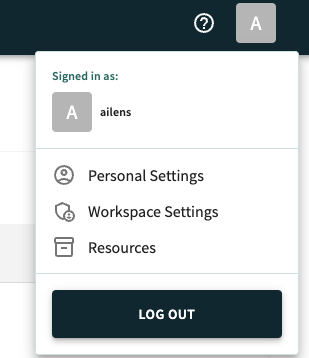

Once you've clicked on "Personal Settings", a pop-up with a button named "Generate Credentials". Click that button.

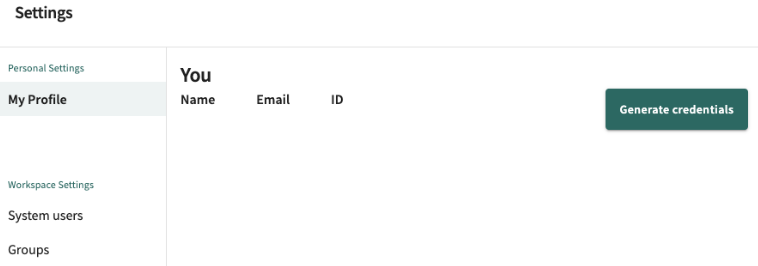

After clicking "Generate Credentials", you will get a pop-up with your authentication token. You can simply click "Copy Auth Token" to add it to your clipboard. After you've done so, just add it to the cell below along with your connection string.

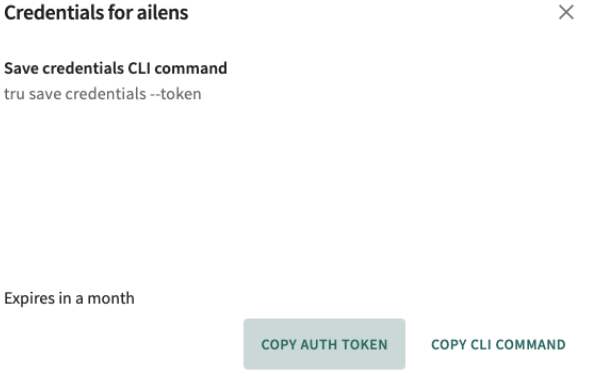

In [ ]:
# FILL ME!

CONNECTION_STRING = ""
AUTH_TOKEN = ""

### Install required packages

In [ ]:
! pip install --upgrade shap
! pip install --upgrade truera

In [ ]:
from truera.client.truera_workspace import TrueraWorkspace
from truera.client.truera_authentication import TokenAuthentication

auth = TokenAuthentication(AUTH_TOKEN)
tru = TrueraWorkspace(CONNECTION_STRING, auth, ignore_version_mismatch=True)

## Step 2: Download sample data
Here we'll use data from scikit-learn's California housing dataset. This can be installed via the `sklearn.datasets` module.

In [ ]:
# Retrieve the data.

import pandas as pd
from sklearn.datasets import fetch_california_housing

data_bunch = fetch_california_housing()
XS_ALL = pd.DataFrame(data=data_bunch["data"], columns=data_bunch["feature_names"])
YS_ALL = pd.Series(data_bunch["target"])

In [ ]:
# Create train and test data splits.

from sklearn.model_selection import train_test_split

XS_TRAIN, XS_TEST, YS_TRAIN, YS_TEST = train_test_split(XS_ALL, YS_ALL, test_size=100)

## Step 3: Create a local project

In [ ]:
tru.set_environment("local")
project_name = "California-Housing"
tru.add_project(project_name, score_type="regression")

## Step 4: Add the data collection and data split
Here we're adding data via simple `pd.DataFrame`s.

In [ ]:
tru.add_data_collection("sklearn_data")
tru.add_data_split(
    data_split_name="all",
    pre_data=XS_ALL,
    label_data=YS_ALL,
    split_type="all")
tru.add_data_split(
    data_split_name="train",
    pre_data=XS_TRAIN,
    label_data=YS_TRAIN,
    split_type="train")
tru.add_data_split(
    data_split_name="test",
    pre_data=XS_TEST,
    label_data=YS_TEST,
    split_type="test")

## Step 5: Train and add a boosted tree regression model

In [ ]:
# Train the model.

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gb_model = GradientBoostingRegressor()
gb_model.fit(XS_TRAIN, YS_TRAIN)
print(f"RMSE = {mean_squared_error(YS_TEST, gb_model.predict(XS_TEST), squared=False)}")



We can add the model itself via [`tru.add_python_model()`](python_sdk_reference.md#truera.client.truera_workspace.TrueraWorkspace.add_python_model), which accepts a number of out-of-the box model frameworks.

In [ ]:
# Add to TruEra workspace.

tru.add_python_model("gradient boosted", gb_model)

In [ ]:
# View ISP.

tru.get_explainer(base_data_split="test").plot_isp(feature='HouseAge')

## Step 6: Sync local project with remote deployment

We've been creating and manipulating our project _locally_ - but how do we explore our project further using the TruEra UI or other features that are only available with a remote deployment? The easiest way is to upload the project to a remote deployment.

Syncing a local project with a remote deployment effectively uploads all artifacts and pre-computed information (such as predictions and influences) to a remote deployment. This will create (or append to) a project of the same name, with all of the data splits and models we just added!

We can upload a local project to a remote environment via [`tru.upload_project()`](python_sdk_reference.md#truera.client.truera_workspace.TrueraWorkspace.upload_project). Similarly, we can download a remote project to a local environment via [`tru.download_project()`](python_sdk_reference.md#truera.client.truera_workspace.TrueraWorkspace.download_project).

In [ ]:
tru.upload_project(upload_error_qiis=True)

View the models on the platform! Once you sync to remote using the upload_project(), head over to the web application at the link below to view Influence Sensitivity Plots, use the Test Harness, check out the Model Leaderboard and more!

In [ ]:
print(CONNECTION_STRING + "/p/" + project_name)

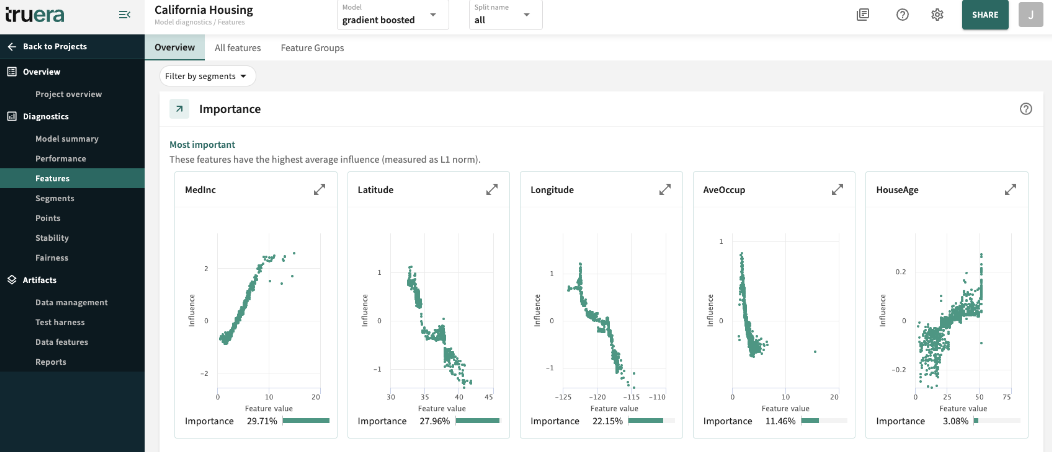